In [27]:
# %load qubit.py
'''Krotov algorithm for Open Quantum Systems! - Version 2.0'''

''' 

d |PSI >> = (-i lambda_1 H_0 - lambda_2^2 L(C)) |PSI>>
-
dt

lambda_1 = lambda_2 ^2
'''

import matplotlib
import scipy.stats
import scipy.linalg
import scipy.sparse.linalg
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy.random as rnd
import scipy
from scipy.integrate import ode

def aprint(args):
    #print(args)
    pass

class Krotov:
    def __init__(self, k, n_bar, omega, lambda_1, t_i, t_f, num_t, target):

        rnd.seed(1814)
        # Hamiltonian
        self.k = float(k)
        self.n_bar = float(n_bar) # n_bar = 1/(e(wB)-1)
        self.omega = float(omega)
        self.lambda_1 = float(lambda_1)
        self.lambda_2 = np.abs(np.sqrt(lambda_1))
        self.t_index = 0
        self.num_basis = 2

        # Sigma Matrices
        self.sigmaX = np.array([[0, 1.], [1., 0]], dtype='complex')
        self.sigmaY = np.array([[0, -1.j], [1.j, 0]], dtype='complex')
        self.sigmaZ = np.array([[1., 0], [0, -1.]], dtype='complex')
        self.I = np.array([[1., 0], [0, 1.]], dtype='complex')
        self.sigmaMinus = 0.5 * (self.sigmaX - 1.j * self.sigmaY)
        self.sigmaPlus = 0.5 * (self.sigmaX + 1.j * self.sigmaY)

        # Time
        self.t_i = t_i
        self.t_f = t_f
        self.num_t = num_t
        self.t = np.linspace(self.t_i, self.t_f, self.num_t)
        self.dt = self.t[1] - self.t[0]

        # Parameters for Krotov
        self.set_Para()

        # Epsilon
        self.Ex = rnd.rand(self.num_t)
        # self.Ex = np.zeros((self.num_t,))
        self.Ex_tilde = np.zeros((self.num_t,))

        # Hamiltonian of the system
        self._H_s = 0.5 * self.sigmaZ * self.omega

        # Density Matrix
        self.col_rho = np.zeros((self.num_t, self.num_basis ** 2), dtype='complex')
        self.col_chi = np.zeros((self.num_t, self.num_basis ** 2), dtype='complex')

        self._rho_init = self.rho_Init()
        self.col_rho[0, :] = self.matrix2col(self._rho_init)

        # Thermal or Target State
        self.target = target
        self.matrix_target_interaction = np.dot(scipy.linalg.expm(1.j * 0.5 * self.omega * self.sigmaZ * self.t[-1]),
                                                np.dot(self.col2matrix(self.target),
                                                       scipy.linalg.expm(
                                                           -1.j * 0.5 * self.omega * self.sigmaZ * self.t[-1])))
        self.target_interaction = self.matrix2col(self.matrix_target_interaction)

        # Time Independent Lindbladian
        self._H_1 = self.H_1()

    # Sets the initial field
    def set_Ex(self, strng="not_zeros"):
        if strng == "zeros":
            self.Ex = np.zeros((self.num_t,))
        else:
            self.Ex = rnd.rand(self.num_t)

    # Sets initial rho
    def set_rho_init(self, array):
        self.col_rho[0] = array

    # Sets the Krotov Parameters : eta, delta, alpha
    def set_Para(self, eta=1., delta=1., alpha=0.0001):
        self.eta = eta
        self.delta = delta
        self.alpha = alpha

    # Stacks the columns of a nXn matrix on top of other and makes a column
    def matrix2col(self, matrix):
        col = np.zeros((0,), dtype='complex')
        for i in range(2):
            col = np.append(col, matrix[:, i])

        return (col)

    def col2matrix(self, col):
        matrix = np.array([[col[0], col[2]], [col[1], col[3]]], dtype='complex')
        return (matrix)

    # Default initial rho
    def rho_Init(self):
        # Z = rnd.rand(2,2) + 1.j * rnd.rand(2,2)
        # Z_dagger = np.transpose(np.conjugate(Z))

        # trace = np.trace(np.dot(Z,Z_dagger))

        # rho = np.dot(Z,Z_dagger) / trace
        rho = 0.5 * np.array([[1, 1], [1, 1]], dtype='complex')
        # rho = np.array([[1,0],[0,0]],dtype='complex')
        return (rho)

    def mu_prime(self, t_index):
       # mu_prime = - (np.cos(self.omega * t_index * self.dt) * self.sigmaX - np.sin(
        #    self.omega * t_index * self.dt) * self.sigmaY)
        mu_prime = self.sigmaX
        return (mu_prime)

    def mu(self, t_index):
        mu = np.kron(self.I, self.mu_prime(t_index)) - np.kron(np.conjugate(self.mu_prime(t_index)), self.I)
        return (mu)

    def H_0(self, t_index):
        return (self.mu(t_index) * self.Ex[t_index])

    def H_0_tilde(self, t_index):
        return (self.mu(t_index) * self.Ex_tilde[t_index])

    # L is Lindblad and C is a matrix
    def L(self, C):
        return (np.kron(np.conjugate(C), C) - 0.5 * (
            np.kron(self.I, np.dot(np.conjugate(np.transpose(C)), C))) - 0.5 * (
                    np.kron(np.dot(np.transpose(C), np.conjugate(C)), self.I)))

    # H_1 : Thermal Lindbladian in Liouville Form
    def H_1(self):
        return (self.L(np.sqrt(2 * self.k * (1 + self.n_bar)) * self.sigmaMinus) + self.L(
            np.sqrt(2 * self.k * self.n_bar) * self.sigmaPlus))

    # Final Liouville Space Hamiltonian

    def H(self, t_index):
        return (-1.j * self.lambda_1 * self.H_0(t_index) + self.lambda_2 ** 2 * self._H_1)

    # H_tilde Relative sign was adjusted from - to +
    def H_tilde(self, t_index):
        return (-1.j * self.lambda_1 * self.H_0_tilde(t_index) + self.lambda_2 ** 2 * self._H_1)

    '''
	The equation becomes 
	d |PSI >> = H(t) |PSI>>
	-
	dt

	We solve it by exponentiation!

	|PSI (t+dt)>> = exp(H(t) dt) |Psi(t)>>0
	'''

    def update_Psi(self, t_index):
        t = t_index
        aprint("psi \n\t t{} Ex{} \n".format(t_index, self.Ex[t]))
        #print("    \n\t Ex~{}\n".format(self.Ex_tilde[t]))
        #print("\t H{} dt{} rhoi{} \n".format(self.H(t), self.dt, self.col_rho[t]))
        column = np.dot(scipy.linalg.expm(self.H(t) * self.dt), self.col_rho[t])
        self.col_rho[t + 1] = column
        #print("\t rhof{}".format(column))

    def update_Chi(self, t_index):
        t = t_index
        #print("psi \n\t t{} Ex{} \n".format(t_index, self.Ex[t]))
        #print("    \n\t Ex~{}\n".format(self.Ex_tilde[t]))
        #print("\t H{} dt{} chii{} \n".format(self.H_tilde(t), self.dt, self.col_chi[t]))
        column = np.dot(scipy.linalg.expm(np.conjugate(np.transpose(-self.H_tilde(t))) * -self.dt), self.col_chi[t])
        #print("\t chif{}".format(column))
        self.col_chi[t - 1] = column

    # Overlap operator with target state O|PSI>>

    def O(self, psi):
        return (np.vdot(self.target_interaction, psi) * self.target_interaction)

    # Returns <<PSI|O|PSI>>>
    def Overlap(self, psi):
        return (np.vdot(psi, self.O(psi)))

    def update_Epsilon(self, t_index):
        t = t_index

        aprint("control \n\t t{} Ex{} \n".format( t, self.Ex))
        aprint("    \n\t Ex~{}\n".format(self.Ex_tilde[t-1]))
        aprint("\t tup{} \n\tchi {}\n\t mu{} \n\t rho{} \n".format(t -1, self.col_chi[t-1], 
                                                                  self.mu(t), self.col_rho[t]))
        aprint("\t p{}  gamma{} alpha{} \n".format(self.delta, self.lambda_1,self.alpha))
        
        part1 = (1 - self.delta) * self.Ex_tilde[t - 1]
        part2 = -self.delta * self.lambda_1 * np.imag(
            np.vdot(self.col_chi[t - 1], np.dot(self.mu(t), self.col_rho[t]))) / self.alpha
        aprint("\t part1{} \n\t part2{}\n".format(part1,part2))

        self.Ex[t] = -(part1 + part2)

    def update_Epsilon_tilde(self, t_index):
        t = t_index
        aprint("control tilde \n\t t{} Ex{} \n".format( t, self.Ex))
        aprint("    \n\t Ex~{}\n".format(self.Ex_tilde[t-1]))
        aprint("\t tup{} \n\tchi {}\n\t mu{} \n\t rho{} \n".format(t, self.col_chi[t], 
                                                                  self.mu(t), self.col_rho[t]))
        aprint("\t p{}  gamma{} alpha{} \n".format(self.delta, self.lambda_1,self.alpha))
        
        part1 = (1 - self.eta) * self.Ex[t]
        part2 = -self.eta * self.lambda_1 * np.imag(
            np.vdot(self.col_chi[t], np.dot(self.mu(t), self.col_rho[t]))) / self.alpha
        self.Ex_tilde[t] = -(part1 + part2)
        aprint("\t part1{} \n\t part2{}\n".format(part1,part2))

    def evolution_Psi(self, string='not initial'):
        if string == 'initial':
            for t in range(0, self.num_t - 1):
                self.update_Psi(t)
        else:
            for t in range(0, self.num_t - 1):
                self.update_Epsilon(t)
                self.update_Psi(t)
            t = self.num_t - 1
            self.update_Epsilon(t)

    def evolution_Chi(self):
        aprint("Evolution Chi")
        for t in range(self.num_t - 1, 0, -1):
            self.update_Epsilon_tilde(t)
            self.update_Chi(t)
        t = 0
        self.update_Epsilon_tilde(t)

    def Run_Krotov(self, num_iter):
        T = self.num_t - 1
        aprint("Ex {}".format(self.Ex))
        self.evolution_Psi('initial')
        aprint("Psi {}".format(self.col_rho))
        self.overlap = []
        self.cost = []
        self.oint = []

        for i in range(0, num_iter):
            aprint("Iteration : {} out of {}".format(i + 1, num_iter))
            self.col_chi[T] = self.O(self.col_rho[T])
            aprint("Chi {}".format(self.col_chi))
            self.evolution_Chi()
            aprint("Chi {}".format(self.col_chi))
            self.evolution_Psi()
            aprint("Psi {}".format(self.col_rho))
            self.overlap.append(self.Overlap(self.col_rho[T]))
            self.oint.append(self.Overlap_Integral())
            self.cost.append(self.J())

    def distance(self,
                 t_index):  # Since trace distance is invariant to unitary transformation, the CIP doesnt change its value.
        t = t_index
        matrix = self.col2matrix(self.col_rho[t])
        diff = self.col2matrix(self.target_interaction) - matrix
        trace_d = np.trace(scipy.linalg.sqrtm(np.dot(diff, np.conjugate(np.transpose(diff)))))
        return (0.5 * trace_d)

    def anal_distance(self, r_fp, rx, ry, rz, t_f, N_iterations, lamda):  # Analytical distance from exact solution.
        Gamma = lamda
        G1 = Gamma / (2.0 * r_fp)  # the 1e-44 is there to prevent the zero temperature case from throwing an exception.
        G2 = 2.0 * G1  # Gamma/r_fp # 2 gamma1
        t = np.linspace(0, t_f, N_iterations)
        dampt = np.exp(-G1 * t)
        damp2t = np.exp(-G2 * t)
        sqrt_fn = np.sqrt((rx ** 2) + (ry ** 2) + ((rz + r_fp) * (rz + r_fp) * damp2t))
        anal_d = (dampt * sqrt_fn)
        return (0.5 * anal_d)

    def Overlap_Integral(self):
        T_index = self.num_t - 1

        ket = self.col_rho[T_index]
        bra = ket
        newKet = self.O(ket)

        val = np.vdot(bra, newKet)

        return (val)

    # Cost Function J
    def J(self):
        integration = scipy.integrate.simps(self.Ex ** 2, x=self.t, dx=self.dt)

        J = self.Overlap_Integral() - self.alpha*integration

        return (J)


def T_epsilon_free(gamma, n_bar, epsilon, initial_rho):
    r_fp = 1 / (2 * n_bar + 1)
    gamma2 = gamma / r_fp
    rho0 = initial_rho
    I = np.array([[1, 0], [0, 1]])

    r = 2 * rho0 - I
    rz_0 = r[0, 0]
    rx_0 = np.real(r[0, 1])
    ry_0 = np.imag(r[0, 1])

    alpha = rx_0 ** 2 + ry_0 ** 2
    beta = rz_0 + r_fp

    T_e_free = np.log((-alpha ** 2 + np.sqrt(alpha ** 4 - 16 * epsilon * beta ** 2)) / (2 * beta ** 2) / (-gamma2))

    return (T_e_free)


def T_final(T_e_free, s):
    return (T_e_free / s)


if __name__ == '__main__':
    # INTITIALIZE : k,n_bar,omega,lambda_1,t_i,t_f,t_num,target

    kappa = 1  # WE have lambda, so set Kappa to 1.
    n_bar = 1  # Being FLOAT is VERY IMPORTANT
    # n_bar = 1/(exp(wB)-1)
    # log(1/n_bar+1) = wB
    omega = 2
    lamda = 1
    N_iterations = 2000
    target = np.array([0.4, 0, 0, 0.6], dtype='complex')
    #nbar/nbar+1 = 2/3 -> 3nbar= 2nbar+2 -> nbar = 2
    times_krotov = 50

    beta1 = np.log((n_bar + 1) / n_bar)/omega

    #beta1 = np.log((n_bar + 1) / n_bar)  # w1*beta1 = f(n_bar) w1: is set to 1
    #beta2 = beta1 / 0.75
    #w1 = 1.  # Don't change from 1 , otherwise beta1 != n_bar+1 / n_bar
    #w2 = 0.25 * w1
#    n_initial = 1 / (np.e ** (beta2 * w2) - 1)
#    initial_rho = np.array([[(n_initial) / (2 * n_initial + 1), 0], [0, (n_initial + 1) / (2 * n_initial + 1)]],
#                           dtype='complex')

    initial_rho = np.array([[0.5, -0.19j], [0.19j, 0.5]], dtype='complex')
    # 0.5 -+ sqrt(0.25-0,0361)
    # 0.7139 2861
    # 0.8nbar = 0.2 -> nbar = 1/4
    epsilon = .01

    T_e_free = np.abs(T_epsilon_free(lamda, n_bar, epsilon, initial_rho))
    _s = 2.
    t_f = T_e_free / _s

    ''' Krotov With Control '''  ######################################
    k = Krotov(kappa, n_bar, omega, lamda, 0, t_f, N_iterations, target)  #
    k.set_rho_init(k.matrix2col(initial_rho))  #
#    k.set_Ex("random")  #
    k.set_Para(eta=1.5, delta=1.5, alpha=0.001)  #
    k.Run_Krotov(times_krotov)  #
    #################################################################


    #plt.plot(range(times_krotov), np.array(k.cost), 'r')
    #plt.savefig('mar-cost.png')
# WITH    KROTOV


In [26]:
k.cost

[(0.28229470845861626+0j)]

/home/marcelo/projects/upwork/Open-Quantum-Systems/venv/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


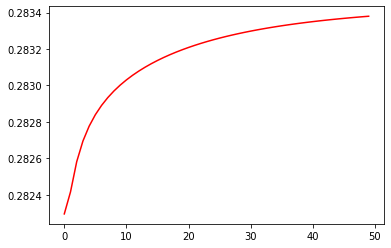

In [29]:
plt.plot(range(times_krotov), k.cost, 'r')

In [30]:
k.col_rho[-1]

array([0.33341343+0.j       , 0.        +0.0021196j,
       0.        -0.0021196j, 0.66658657+0.j       ])